In [36]:
%load_ext autoreload
%autoreload 2
import os
import sys
import logging
import pandas as pd
import numpy as np
import imblearn as imb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from rdkit import Chem
from rdkit.Chem import Draw
from imblearn.under_sampling import RandomUnderSampler
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
smile_prop_df = pd.read_csv('/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK3/NEK3_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

# Reading in the training set (folds 1-4) and the test set (fold 5)
smile_prop_train = smile_prop_df[smile_prop_df['fold'] != 'fold5'].drop(columns=['fold'])
smile_prop_test = smile_prop_df[smile_prop_df['fold'] == 'fold5'].drop(columns=['fold'])

# Converting the SMILES to RDKit mol objects and assigning name and activity to each mol object
mol_train = []
for i in smile_prop_train.index:
    m = Chem.MolFromSmiles(smile_prop_train.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_train.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_train.loc[i, 'active']))
        mol_train.append(utils.normalize(m))

mol_test = []
for i in smile_prop_test.index:
    m = Chem.MolFromSmiles(smile_prop_test.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_test.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_test.loc[i, 'active']))
        mol_test.append(utils.normalize(m))


[21:20:57] Initializing MetalDisconnector
[21:20:57] Running MetalDisconnector
[21:20:57] Initializing Normalizer
[21:20:57] Running Normalizer
[21:20:57] Running LargestFragmentChooser
[21:20:57] Running Uncharger
[21:20:57] Initializing MetalDisconnector
[21:20:57] Running MetalDisconnector
[21:20:57] Initializing Normalizer
[21:20:57] Running Normalizer
[21:20:57] Initializing MetalDisconnector
[21:20:57] Running MetalDisconnector
[21:20:57] Initializing Normalizer
[21:20:57] Running Normalizer
[21:20:57] Running LargestFragmentChooser
[21:20:57] Running Uncharger
[21:20:57] Initializing MetalDisconnector
[21:20:57] Running MetalDisconnector
[21:20:57] Initializing Normalizer
[21:20:57] Running Normalizer
[21:20:57] Initializing MetalDisconnector
[21:20:57] Running MetalDisconnector
[21:20:57] Initializing Normalizer
[21:20:57] Running Normalizer
[21:20:57] Running LargestFragmentChooser
[21:20:57] Running Uncharger
[21:20:57] Initializing MetalDisconnector
[21:20:57] Running MetalD

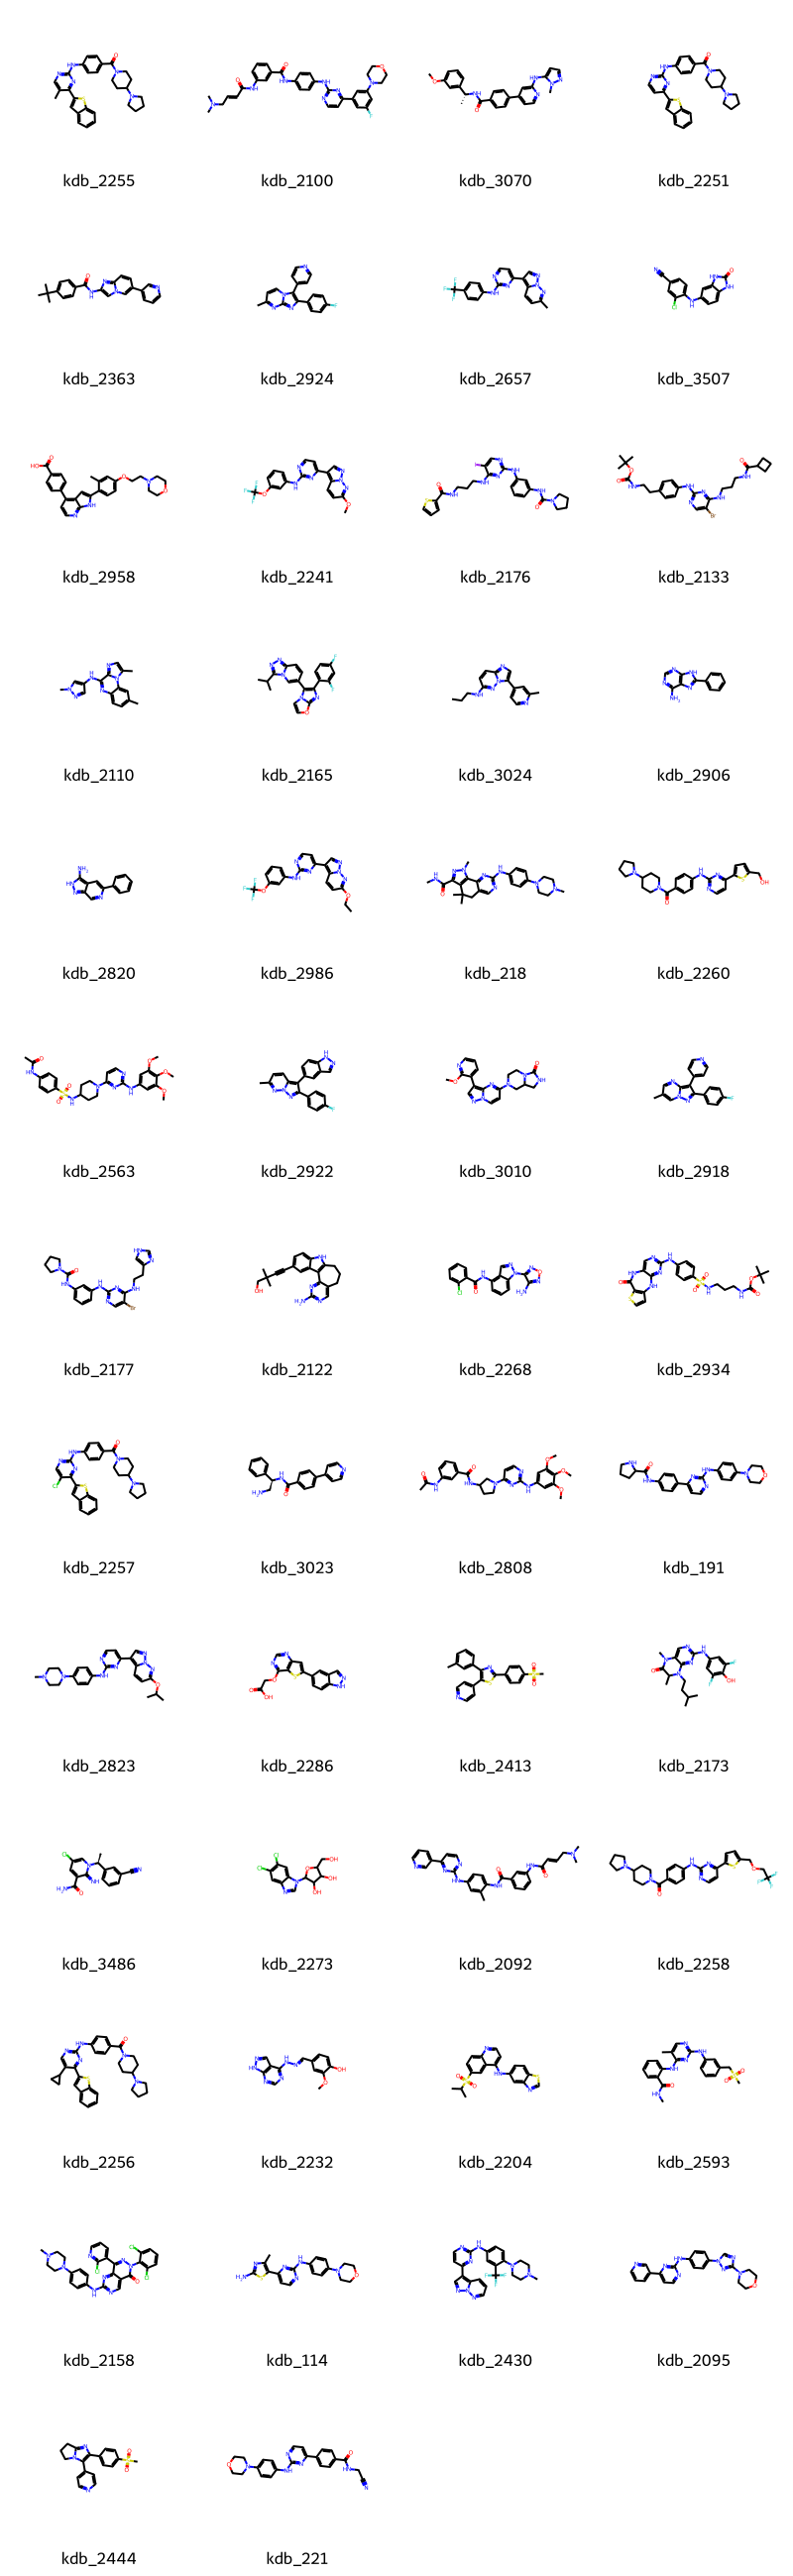

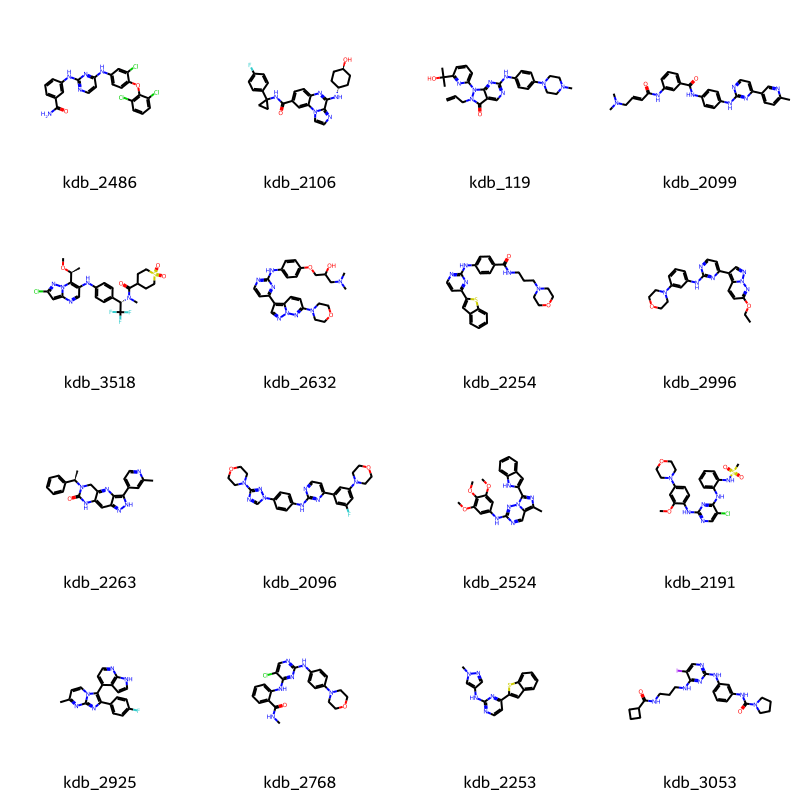

In [6]:
# Diaplaying the active compounds in the training and test set

active_train = []

for m in mol_train:
    if m.GetProp("Active") == '1':
        tmp=Chem.AllChem.Compute2DCoords(m)
        active_train.append(m)

display(Draw.MolsToGridImage(active_train,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_train]))

active_test = []
for m in mol_test:
    if m.GetProp("Active") == '1':
        tmp=Chem.AllChem.Compute2DCoords(m)
        active_test.append(m)

display(Draw.MolsToGridImage(active_test,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_test]))


In [8]:
import os
from rdkit import Chem

# Create the directory if it does not exist
directory = 'data/NEK2'
if not os.path.exists(directory):
    os.makedirs(directory)

# Proceed with writing your files
with Chem.SDWriter(os.path.join(directory, 'NEK3_1_uM_min_50_pct_binding_5fold_random_imbalanced_train.sdf')) as writer:
    for m in mol_train:
        writer.write(m)

with Chem.SDWriter(os.path.join(directory, 'NEK3_1_uM_min_50_pct_binding_5fold_random_imbalanced_test.sdf')) as writer:
    for m in mol_test:
        writer.write(m)


In [9]:
# Generating the existing and morgan fingerprints for the training and test set

X_existing_train = smile_prop_train.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
X_existing_test = smile_prop_test.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
y_train = smile_prop_train['active']
y_test = smile_prop_test['active']

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_train]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_train = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_train.append(arr)

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_test]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_test = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_test.append(arr)


In [10]:
# Function: Random Forest search model generator with stats
def rf_search_model(X_train, y_train, X_test, y_test,random_grid):
    rf = RandomForestClassifier(random_state = 42)
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    y_pred = rf_random.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, conf_matrix

# Function: Random Forest model generator with stats
def rf_model(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(random_state = 42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, conf_matrix


In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Accuracy: 0.9428571428571428


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Confusion Matrix test for NEK 3 RF Model w/ RD kit Fingerprints')

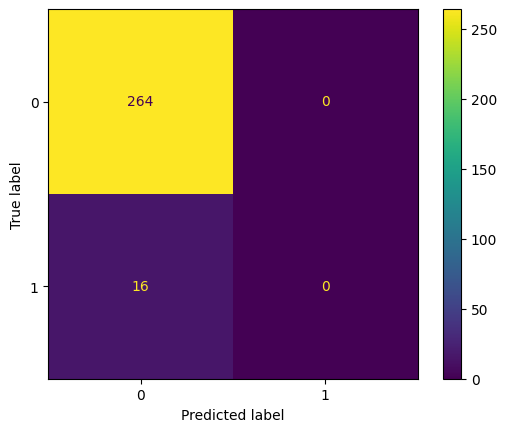

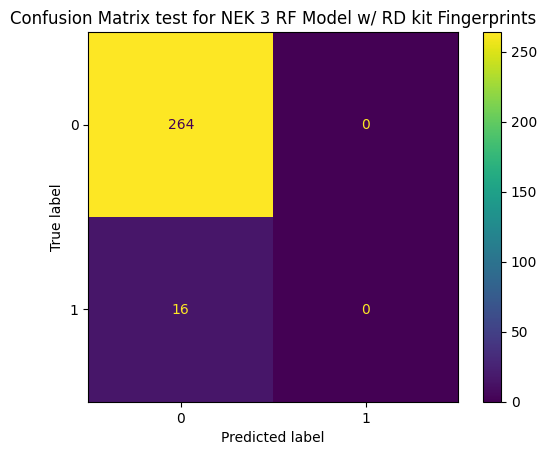

In [32]:
# RF model with existing fingerprints
accuracy, precision, recall, conf_matrix = rf_model(X_existing_train, y_train, X_existing_test, y_test)

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 3 RF Model w/ RD kit Fingerprints')

Accuracy: 0.95


Text(0.5, 1.0, 'Confusion Matrix test for NEK 3 RF Model w/ Morgan Fingerprints')

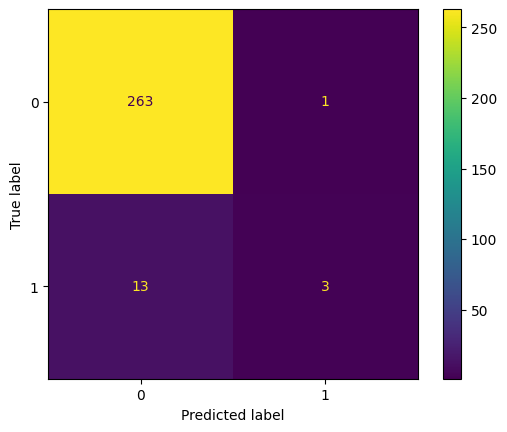

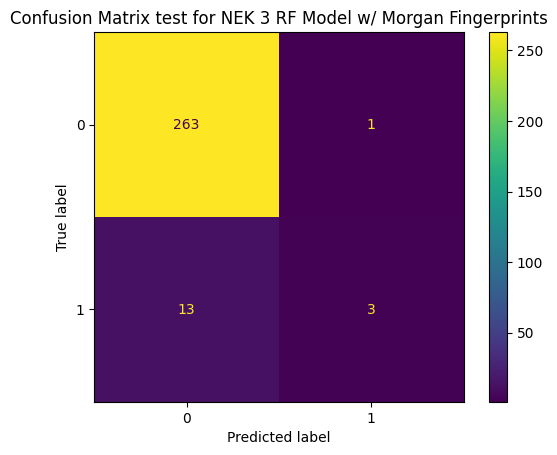

In [31]:
# RF model with morgan fingerprints
accuracy, precision, recall, conf_matrix = rf_model(X_morgan_train, y_train, X_morgan_test, y_test)

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 3 RF Model w/ Morgan Fingerprints')

Accuracy: 0.9428571428571428


Text(0.5, 1.0, 'Confusion Matrix test for NEK 3 RF Model w/ RD kit and oversampling')

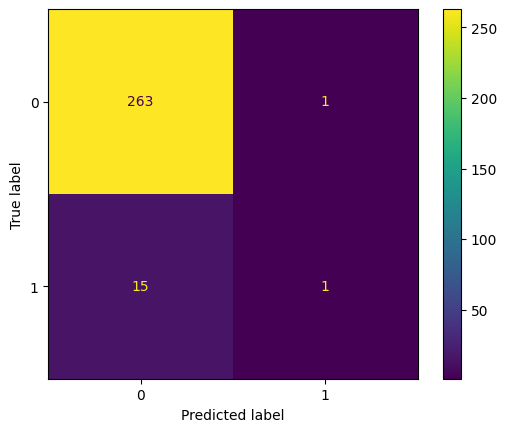

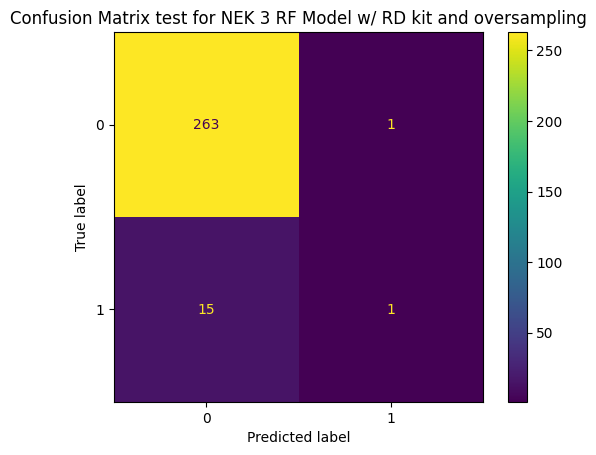

In [30]:
# RF model with existing fingerprints using oversampling
oversample = imb.over_sampling.RandomOverSampler()
X_os_train, y_os_train = oversample.fit_resample(X_existing_train, y_train)

accuracy, precision, recall, conf_matrix = rf_model(X_os_train, y_os_train, X_existing_test, y_test)

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 3 RF Model w/ RD kit and oversampling')

Accuracy: 0.95


Text(0.5, 1.0, 'Confusion Matrix test for NEK 3 RF Model w/ RD kit and oversampling')

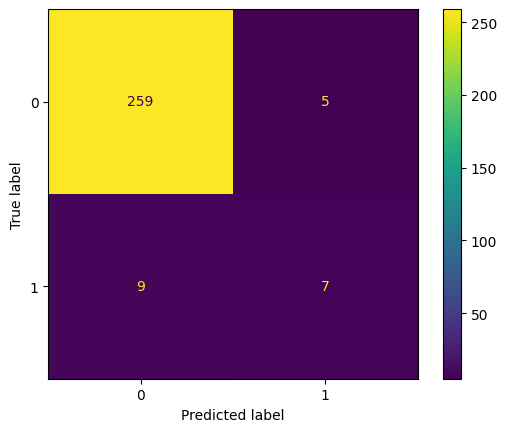

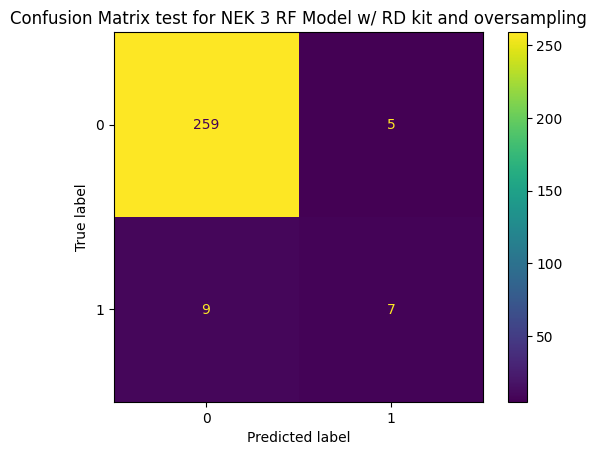

In [38]:
# RF model with morgan fingerprints using oversampling
oversample = imb.over_sampling.RandomOverSampler()
X_os_train, y_os_train = oversample.fit_resample(X_morgan_train, y_train)

accuracy, precision, recall, conf_matrix = rf_model(X_os_train, y_os_train, X_morgan_test, y_test)

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 3 RF Model w/ RD kit and oversampling')

Accuracy: 0.5035714285714286


Text(0.5, 1.0, 'Confusion Matrix for NEK 3 RF Model w/ RD kit and Under Sampling')

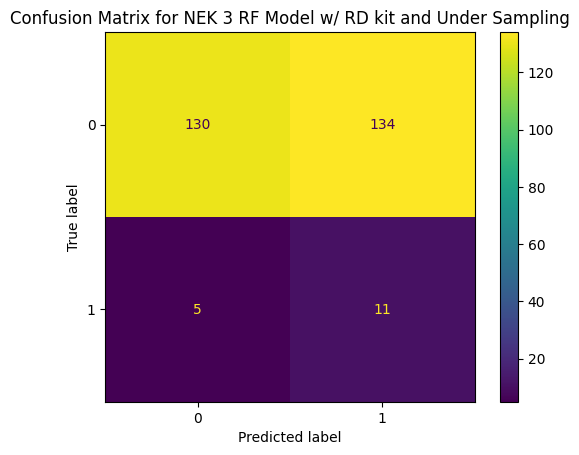

In [37]:


# Initialize the under-sampler
undersample = RandomUnderSampler()

# Apply the under-sampler to the training data
X_us_train, y_us_train = undersample.fit_resample(X_existing_train, y_train)

# Assuming rf_model is defined and works correctly
accuracy, precision, recall, conf_matrix = rf_model(X_us_train, y_us_train, X_existing_test, y_test)

print("Accuracy:", accuracy)

# Create and display the confusion matrix with a title

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
ax = disp.plot().ax_
ax.set_title('Confusion Matrix for NEK 3 RF Model w/ RD kit and Under Sampling')

Accuracy: 0.7964285714285714


Text(0.5, 1.0, 'Confusion Matrix for NEK 3 RF Model Morgan Fingerprint and Under Sampling')

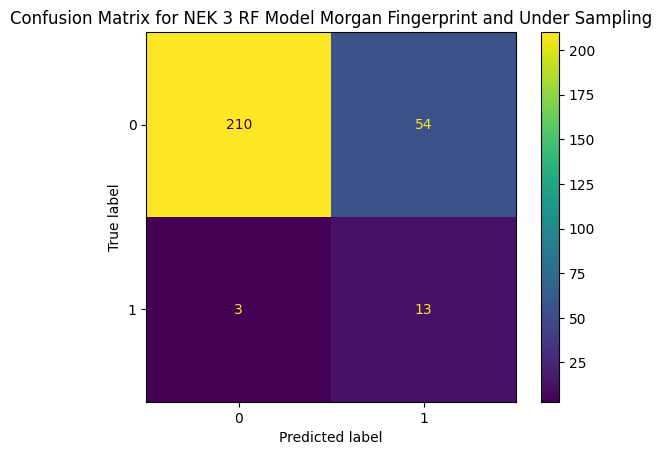

In [39]:
# Initialize the under-sampler
undersample = RandomUnderSampler()

# Apply the under-sampler to the training data
X_us_train, y_us_train = undersample.fit_resample(X_morgan_train, y_train)

# Assuming rf_model is defined and works correctly
accuracy, precision, recall, conf_matrix = rf_model(X_us_train, y_us_train, X_morgan_test, y_test)

print("Accuracy:", accuracy)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
ax = disp.plot().ax_
ax.set_title('Confusion Matrix for NEK 3 RF Model Morgan Fingerprint and Under Sampling')

Accuracy: 0.9428571428571428


Text(0.5, 1.0, 'Confusion Matrix test for NEK 3 RF Model w/  Morgan Fingerprint and oversampling')

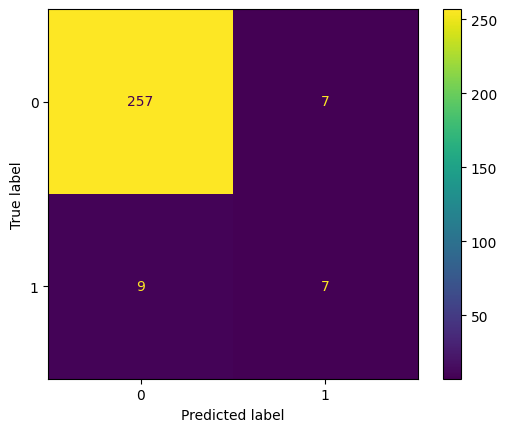

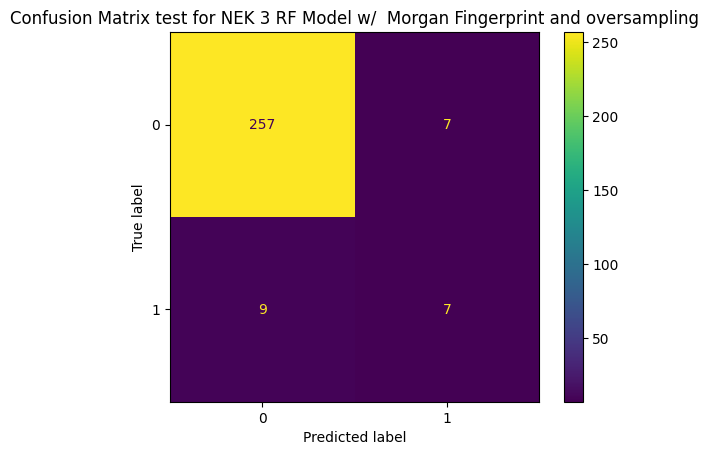

In [33]:

xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_morgan_train, y_train)
accuracy = xgb_model.score(X_morgan_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_morgan_test))

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 3 RF Model w/  Morgan Fingerprint and oversampling')

Accuracy: 0.9428571428571428


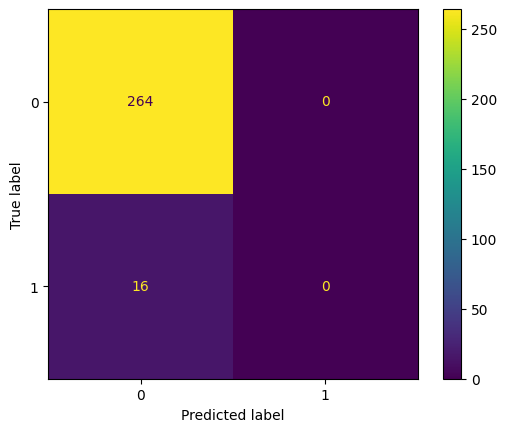

In [17]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_existing_train, y_train)
accuracy = xgb_model.score(X_existing_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_existing_test))

print("Accuracy:", accuracy)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();

Accuracy: 0.925


Text(0.5, 1.0, 'Confusion Matrix test for NEK 3 XG Boost Model w/ RD kit')

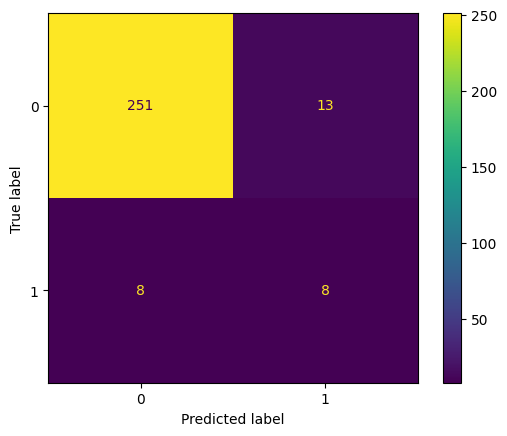

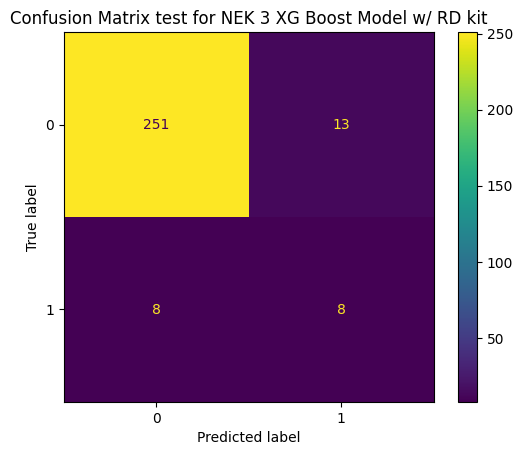

In [34]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
X_os_train, y_os_train = oversample.fit_resample(X_morgan_train, y_train)

xgb_model.fit(X_os_train, y_os_train)
accuracy = xgb_model.score(X_morgan_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_morgan_test))

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 3 XG Boost Model w/ RD kit')

Accuracy: 0.9428571428571428


Text(0.5, 1.0, 'Confusion Matrix test for NEK 3 XG Boost Model w/ Morgan Fingerprint')

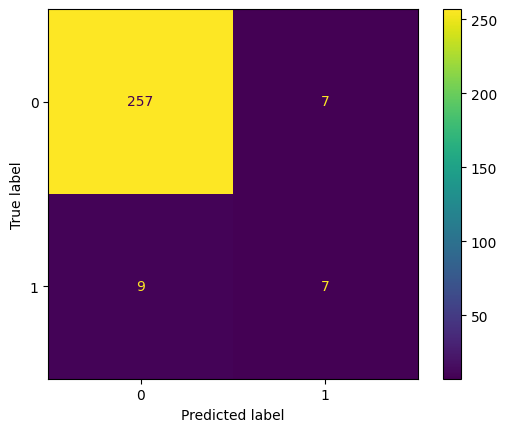

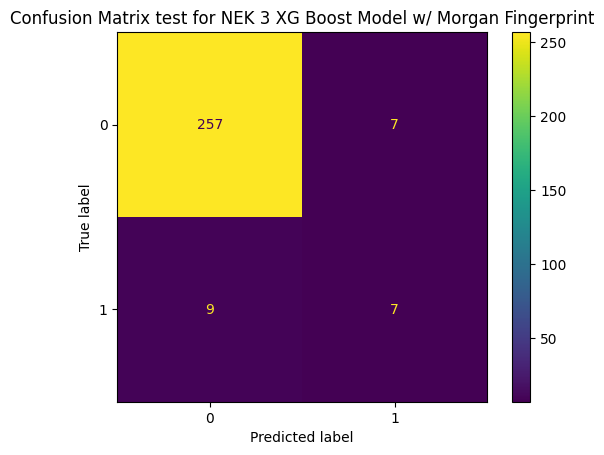

In [35]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_morgan_train, y_train)
accuracy = xgb_model.score(X_morgan_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_morgan_test))

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 3 XG Boost Model w/ Morgan Fingerprint')